# In this notebook, simple RNN will be used to predict the closing price of Bitcoin

* Any feedback is welcome!!

reference: Deep learning with Python (some lines of code are extracted and modified from this book)
1. https://www.manning.com/books/deep-learning-with-python

# Please refer to the kernel below for data exploration
https://www.kaggle.com/kentata/time-series-data-exploration

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
# Input data files are available in the "../input/" directory.


from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

bitcoin_price_1week_Test - Test.csv
bitcoin_price_Training - Training.csv



In [2]:
train = pd.read_csv("../input/bitcoin_price_Training - Training.csv")
test = pd.read_csv("../input/bitcoin_price_1week_Test - Test.csv")

In [3]:
train = train[::-1]
test = test[::-1]

In [4]:
train.head()

,Date,Open,High,Low,Close,Volume,Market Cap
1555,"Apr 28, 2013",135.30,135.98,132.10,134.21,-,"1,500,520,000"
1554,"Apr 29, 2013",134.44,147.49,134.00,144.54,-,"1,491,160,000"
1553,"Apr 30, 2013",144.00,146.93,134.05,139.00,-,"1,597,780,000"
1552,"May 01, 2013",139.00,139.89,107.72,116.99,-,"1,542,820,000"
1551,"May 02, 2013",116.38,125.60,92.28,105.21,-,"1,292,190,000"


In [5]:
train = train['Close'].values.astype('float32')
test = test['Close'].values.astype('float32')

# Make sure to standardize the data before feeding it to neural nets

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
# reshape data to scale the point
train = train.reshape(-1, 1)
test = test.reshape(-1, 1)

scaler = StandardScaler()
train_n = scaler.fit_transform(train)
test_n = scaler.transform(test)

In [8]:
print(train_n.shape)
print(test_n.shape)

(1556, 1)
(7, 1)


In [9]:
def generator(data, lookback, delay, min_index, max_index, 
              shuffle=False, batch_size=128, step=1):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
                
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay]
        yield samples, targets

**Hyperparameters:**

lookback: how many points (days) shoud be used as inputs to predict the future value

delay: how many points should be predicted

Ex: In this example, we use previous prices for 24 days as input  to predict the prices for future 7 days

The reason why I chose thses values are:

lookback: 24 is the value chosen by autoregressive model (https://www.kaggle.com/kentata/time-series-data-exploration)

delay: test data has 7 points(daily values) so prediction and true values wiill be possible


In [10]:
lookback = 24
step = 1
delay = 7
batch_size = 128
train_gen = generator(train_n, lookback=lookback, delay=delay,
    min_index=0, max_index=1000, shuffle=True, step=step,
batch_size=batch_size)
val_gen = generator(train_n, lookback=lookback, delay=delay,
    min_index=1001, max_index=None, step=step, batch_size=batch_size)
test_gen = generator(test_n, lookback=lookback, delay=delay,
    min_index=0, max_index=None, step=step, batch_size=batch_size)
# This is how many steps to draw from `val_gen` in order to see the whole validation set:
val_steps = (len(train_n) - 1001 - lookback) // batch_size
# This is how many steps to draw from `test_gen` in order to see the whole test set:
test_steps = (len(test_n) - lookback) // batch_size

In [11]:
# reproducibility (make sure each time training is occurred, the result will be the same)
np.random.seed(7)

In [12]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [13]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, train_n.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                3264      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 3,297
Trainable params: 3,297
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 27s - loss: 0.1584 - val_loss: 0.4345
Epoch 2/40
500/500 [==============================] - 27s - loss: 0.1430 - val_loss: 0.4519
Epoch 3/40
500/500 [==============================] - 27s - loss: 0.1186 - val_loss: 0.4737
Epoch 4/40
500/500 [==============================] - 27s - loss: 0.1090 - val_loss: 0.5225
Epoch 5/40
500/500 [==============================] - 27s - loss: 0.1054 - val_loss: 0.5584
Epoch 6/40
500/500 [==============================] - 27s - loss: 0.1023 - val_loss: 0.5431
Epoch 7/40
500/500 [==============================] - 27s - loss: 0.1011 - val_loss: 0.5546
Epoch 8/40
500/500 [==============================] - 27s - loss: 0.0983 - val_loss: 0.5800
Epoch 9/40
500/500 [==============================] - 27s - loss: 0.0930 - val_loss: 0.5425
Epoch 10/40
500/500 [==============================] - 27s - loss: 0.0911 - val_loss: 0.5513
Epoch 11/40
500/500 [==============================] - 26s - loss: 0.0866 - val

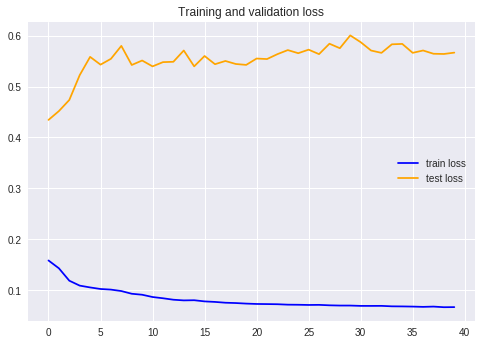

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'blue', label='train loss')
plt.plot(epochs, val_loss, 'orange', label='test loss')
plt.title('Training and validation loss')
plt.legend()

Important to note: Overfitting. Further hyperparamter tuing is necessary (strong drop-out, regularization)

In [16]:
train_re = train_n.reshape(-1,1,1)
pred = model.predict(train_re)

Since we scaled the data, it is necessary to scale back to data in original units to plot the data

In [17]:
pred = scaler.inverse_transform(pred)

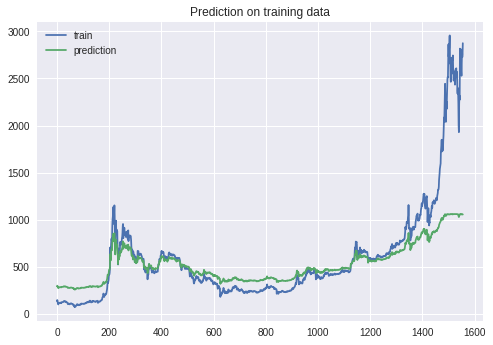

In [18]:
plt.plot(range(len(train_re)), train, label='train')
plt.plot(range(len(train_re)), pred, label='prediction')
plt.legend()
plt.title("Prediction on training data")

# Important to note: prediction does not capture the steep increase of price from 1400 days (prediction performs well unitl 1400 days). This might be due to the abrupt change which is hard to predict